# Prior Identification of Students Withdrawal from Online Courses using Machine and Deep Learning Techniques

In [1]:
#import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout

from keras import Input, layers
from keras.layers.merge import add
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#Load the demographic and VLE data from the OULAD
students = pd.read_csv('studentInfo.csv')
vle= pd.read_csv('vle.csv')
svle=pd.read_csv('studentVle.csv')

# Demographic Data

In [3]:
students.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


The source data only consists of records belonging to year 2013 and 2014.

However, the model should be robust enough to make predictions in real time for the students enrolled in any particular year.

Hence,  more generic presentation i.e. “B” and “J” will be considered in this research to avoid any year dependency.  

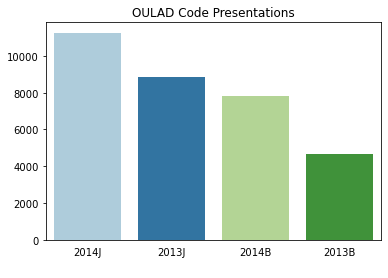

In [4]:
sns.countplot('code_presentation',data=students,order = students['code_presentation'].value_counts().index,palette='Paired')
plt.ylabel('')
plt.xlabel(' ')
plt.title('OULAD Code Presentations')
plt.tick_params(bottom=False)

In [5]:
# Check the missing entries in OUTLAD
students.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [6]:
#Impute the missing values
students.imd_band.fillna('20-30%',inplace=True)

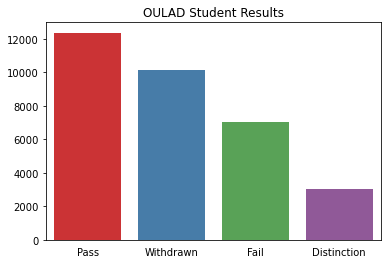

In [7]:
sns.countplot('final_result',data=students,palette='Set1')
plt.ylabel('')
plt.xlabel(' ')
plt.title('OULAD Student Results')
plt.tick_params(bottom=False)

There are four categories of results. This research aims to predict the students that will either continue the course or Withdraw from a course.

Hence, records from three categories are considered (Pass, Withdraw and Distinction). The Pass and Distinction will be combined as the 
Pass category.

This becomes a binary classification problem to predict whether students dropout from course or not. 

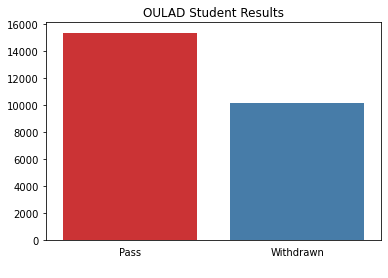

In [8]:
cat= ['Pass','Withdrawn','Distinction']
students =students[students['final_result'].isin(cat)]
students.final_result = students.final_result.apply(lambda x: x  if x=='Withdrawn' else 'Pass')
sns.countplot('final_result',data=students,palette='Set1')
plt.ylabel('')
plt.xlabel(' ')
plt.title('OULAD Student Results')
plt.tick_params(bottom=False)

In [9]:
#class distribution
students.final_result.value_counts()

Pass         15385
Withdrawn    10156
Name: final_result, dtype: int64

In [10]:
# Map Pass to 1 and Withdraw to 0
students.final_result = students.final_result.apply(lambda x: 1 if x=="Pass" else 0)


# Logistic Regression on Demographic Data

In [12]:
demo_data=students.copy()

No handles with labels found to put in legend.


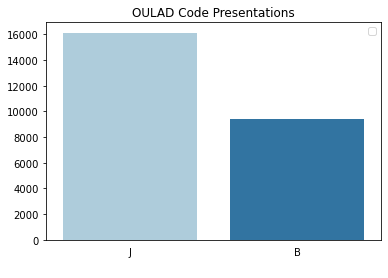

In [13]:
# Select only the semester month part of the presentation i.e. "B" or "J" respectively

demo_data['code_presentation']=demo_data.code_presentation.apply(lambda x: str(x)[-1])

sns.countplot('code_presentation',data=demo_data,order = demo_data['code_presentation'].value_counts().index,palette='Paired')
plt.ylabel('')
plt.xlabel(' ')
plt.legend()
plt.title('OULAD Code Presentations')
plt.tick_params(bottom=False)

In [14]:
#Create dummy variables and train the LR model

df = pd.get_dummies(demo_data, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)

y = df.final_result
X = df.drop(['final_result','id_student'],axis=1)

x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=0)

lr= LogisticRegression()
lr.fit(x_train_d,y_train_d)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Check for Data Imbalance in the Training Set : There are 11550 Pass instances and only 7605 withdrawn instances. 

In [16]:
y_train_d.value_counts()

1    11550
0     7605
Name: final_result, dtype: int64

In [17]:
y_pred=lr.predict(x_test_d)
print("")
print("         Logistic Regression Results on Demographic Details without SMOTE")
print("")
print("  Accuracy: %.4f   F-Score:  %.2f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)),\
      "\t   10-fold  Accuracy %.2f   F-Score:  %.2f" %(cross_val_score(lr,x_train_d,y_train_d,cv=10).mean()*100,\
                                                   cross_val_score(lr, x_train_d, y_train_d, cv=10, scoring='f1').mean()))



         Logistic Regression Results on Demographic Details without SMOTE

  Accuracy: 66.2386   F-Score:  0.75 	   10-fold  Accuracy 66.35   F-Score:  0.75


The main objective of this research is to predict maximum number of students that could dropout from a course. 

The below confusion matrix shows the model correctly predicted 1019 withdrawn instances. To improve the model performance correct withdrawn predictions should increase.

In [20]:
matrix=confusion_matrix(y_test_d,y_pred)

In [21]:

print("\t\t\tActual Withdrawn\tActual Pass")
print("Predicted Withdrawn \t{}\t\t\t{} \nPredcited Pass \t\t{}\t\t\t{}".format(matrix[0][0],matrix[0][1],matrix[1][0],matrix[1][1]))


			Actual Withdrawn	Actual Pass
Predicted Withdrawn 	1019			1532 
Predcited Pass 		624			3211


## SMOTE Analysis on Demographic Data

The LR results seen above seem to be baised towards class Pass. This can be observed below, the training dataset is imbalanced and has  more data points related to the Pass Category. SMOTE  method helps to overcome this issue by oversampling the instances for Withdraw category.

In [22]:
y_train_d.value_counts()

1    11550
0     7605
Name: final_result, dtype: int64

In [23]:
#Implement SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_train_res, y_train_res = sm.fit_sample(x_train_d, y_train_d.ravel())

lr= LogisticRegression()
lr.fit(X_train_res,y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred = lr.predict(x_test_d)
print("")
print("       Logistic Regression Results on Demographic Details with SMOTE")
print("")
print("  Accuracy: %.4f   F-Score:  %.2f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)),\
      "\t   10-fold  Accuracy %.2f   F-Score:  %.2f" %(cross_val_score(lr,X_train_res,y_train_res,cv=10).mean()*100,\
                                                   cross_val_score(lr, X_train_res, y_train_res, cv=10, scoring='f1').mean()))



       Logistic Regression Results on Demographic Details with SMOTE

  Accuracy: 64.0620   F-Score:  0.69 	   10-fold  Accuracy 65.01   F-Score:  0.66


As seen below, with this oversampling technique 1504 students are correctly classified as Withdraw.

In [25]:
matrix=confusion_matrix(y_test_d,y_pred)

In [26]:
print("\t\t\tActual Withdrawn\tActual Pass")
print("Predicted Withdrawn \t{}\t\t\t{} \nPredicted Pass \t\t{}\t\t\t{}".format(matrix[0][0],matrix[0][1],matrix[1][0],matrix[1][1]))


			Actual Withdrawn	Actual Pass
Predicted Withdrawn 	1504			1047 
Predicted Pass 		1248			2587


# VLE Data

The student interactions with the online platform are recorded and will be analyzed to predict the withdrawals.

In [11]:
svle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


# Pre-Processing

It is important to identify the students that can withdraw a course in the early weeks of the course duration. Hence, it is necessary to perform the student analysis on a weekly basis. The date reported of accessing the materials needs to be mapped accordingly to respective week numbers.

In [12]:
date_to_be_mapped =svle.date.unique()
date_week_mapping ={}

In [13]:
# map the date to its respectiev week number
date_week_mapping[0]=0
for date in date_to_be_mapped:
    start =1
    end =7
    for week in range(0,39):
        if date>0:                                        # Check for date after course starts
            if date >= start and date<=end:
                date_week_mapping[date]= week
                break 
        else:                                             # Check for date where student access the course before it starts
            temp_date = -date
            if temp_date >= start and temp_date<=end:
                date_week_mapping[date]= -(week+1)
                break 
        start= start+ 7 
        end = end +7

The date of each interaction is mapped to its corresponding week number(0-38) of the ongoing course. 

Besides, some interactions are associated with negative week number. These interactions correspond to 0-4 weeks before the module presentation begins. 

Negative week represent those students that access the VLE content weeks before the course starts.

In [14]:
# Add the week Column to the dataframe
svle['week']= svle.date.apply(lambda x : date_week_mapping[x])
svle.head(3)

,code_module,code_presentation,id_student,id_site,date,sum_click,week
0,AAA,2013J,28400,546652,-10,4,-2
1,AAA,2013J,28400,546652,-10,1,-2
2,AAA,2013J,28400,546652,-10,1,-2


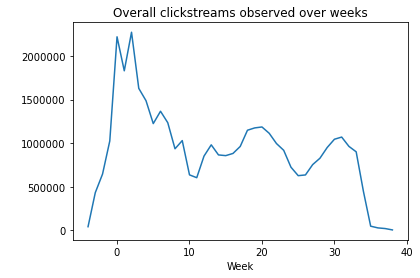

In [15]:
# clickstreams pattern observed over the 38 weeks
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
svle.groupby('week').sum_click.sum().plot(kind="line",ax=ax)
plt.xlabel('Week')
plt.ylabel(' ')
plt.title('Overall clickstreams observed over weeks')
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

The VLE clicks are observed across the Pass and Withdrawn categories

In [16]:
merged_data =pd.merge(svle,students,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
passed_cases=merged_data[merged_data.final_result==1]
withdrawn_cases=merged_data[merged_data.final_result==0]

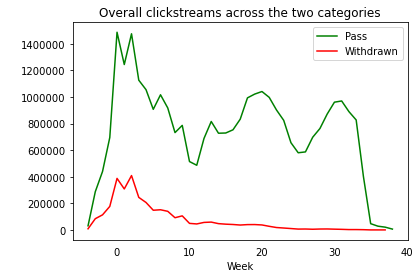

In [17]:
# clickstreams pattern observed over the 38 weeks for both the categories
fig, ax = plt.subplots()
passed_cases.groupby(['week']).sum_click.sum().plot(kind="line",ax=ax,color='green',label="Pass")
withdrawn_cases.groupby(['week']).sum_click.sum().plot(kind="line",ax=ax,color='red',label="Withdrawn")
plt.xlabel('Week')
plt.ylabel(' ')
plt.legend()
plt.title('Overall clickstreams across the two categories')
ax.ticklabel_format(useOffset=False, style='plain')
plt.tick_params(bottom=False)

In [18]:
print("               Data Statistics              ")
print("")
print("Total Withdraw Clicks:              ", withdrawn_cases['sum_click'].sum())
print("Total Pass Clicks:                  ", passed_cases['sum_click'].sum())
print("Student count in Pass category      ", passed_cases.id_student.nunique())
print("Student count in Withdrawn category ", withdrawn_cases.id_student.nunique())

               Data Statistics              

Total Withdraw Clicks:               3188477
Total Pass Clicks:                   31819757
Student count in Pass category       14578
Student count in Withdrawn category  6557


For each student the clickstreams are aggregated week-wise to perform analysis on a weekly basis.

In [19]:
data = svle.groupby(['code_module','code_presentation','id_student','week']).sum_click.sum().reset_index()
data.head(3)

,code_module,code_presentation,id_student,week,sum_click
0,AAA,2013J,11391,-1,98
1,AAA,2013J,11391,0,183
2,AAA,2013J,11391,1,20


Convert the data into wide format to get details of each student and respective courses with all the weeks in a single row. 

In [20]:
week_processed =data.reset_index().groupby(['code_module','code_presentation','id_student','week'])['sum_click'].aggregate('first').unstack().reset_index()
week_processed.fillna(0,inplace=True)
week_processed.head(3)

week,code_module,code_presentation,id_student,-4,-3,-2,-1,0,1,2,...,29,30,31,32,33,34,35,36,37,38
0,AAA,2013J,11391,0.0,0.0,0.0,98.0,183.0,20.0,100.0,...,43.0,0.0,35.0,15.0,0.0,92.0,0.0,1.0,0.0,0.0
1,AAA,2013J,28400,0.0,0.0,79.0,136.0,182.0,59.0,37.0,...,21.0,88.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AAA,2013J,30268,0.0,0.0,14.0,88.0,107.0,72.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Demographic details are also considered, hence combining the demographic and VLE interactions data.

In [21]:
student_week_data=  pd.merge(students,week_processed,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
student_week_data.head(3)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,29,30,31,32,33,34,35,36,37,38
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,43.0,0.0,35.0,15.0,0.0,92.0,0.0,1.0,0.0,0.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,21.0,88.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# LR on Demographics and clickstreams aggregated by weeks

It will be useful to perform a prior identification of the dropouts to make the predictions in the real time.

Hence it would be useful to analyse the performance of the model after week 05, week 10 , week 15 etc. 

In [49]:
def vle_week_wise_analysis(student_week_data, week_selection, week_no, check_confusion_matrix, if_smote):
    
    student_week_data = student_week_data.iloc[:,0:week_selection]
    stu_vle_data=student_week_data.copy()
    stu_vle_data['code_presentation']=stu_vle_data.code_presentation.apply(lambda x: str(x)[-1])
    
    w_df = pd.get_dummies(stu_vle_data, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
    y = w_df.final_result
    X = w_df.drop(['final_result','id_student'],axis=1)
    x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=1)
    lr= LogisticRegression()
    
    if(if_smote):
        sm = SMOTE(random_state=1)
        x_train_d, y_train_d = sm.fit_sample(x_train_d, y_train_d.ravel())
            
    lr.fit(x_train_d,y_train_d)
    y_pred= lr.predict(x_test_d)
    
    if(check_confusion_matrix):
        matrix=confusion_matrix(y_pred,y_test_d)
        print("\t\t\tActual Withdrawn\tActual Pass")
        print("Predicted Withdrawn \t{}\t\t\t{} \nPredicted Pass \t\t{}\t\t\t{}".format(matrix[0][0],matrix[0][1],matrix[1][0],matrix[1][1]))
    
    else:
        print("Week",week_no,"  Accuracy: %.2f  F-Score:  %.2f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)),"\t10-fold  Accuracy %.2f\tF-Score:  %.2f" %(cross_val_score(lr,x_train_d,y_train_d,cv=10).mean()*100,cross_val_score(lr, x_train_d, y_train_d, cv=10, scoring='f1').mean()))


In [50]:
# data for demographics and week 05 clicks correspond to 22 columns, demographics and week 10 clicks correspond to 27 etc.

print("\t\t\t  Clickstreams Aggregated by Weeks")
print()
print("   Logistic Regression Results Without SMOTE  ")
print()
vle_week_wise_analysis(student_week_data,22,'05',False,False)
vle_week_wise_analysis(student_week_data,27,'10',False,False)
vle_week_wise_analysis(student_week_data,32,'15',False,False)
vle_week_wise_analysis(student_week_data,37,'20',False,False)
vle_week_wise_analysis(student_week_data,42,'25',False,False)
print()
print("   Confusion Matrix for Week 5 without SMOTE")
print()
vle_week_wise_analysis(student_week_data,22,'05',True,False)

			  Clickstreams Aggregated by Weeks

   Logistic Regression Results Without SMOTE  

Week 05   Accuracy: 76.21  F-Score:  0.84 	10-fold  Accuracy 76.02	F-Score:  0.84
Week 10   Accuracy: 79.99  F-Score:  0.86 	10-fold  Accuracy 79.53	F-Score:  0.86
Week 15   Accuracy: 83.22  F-Score:  0.88 	10-fold  Accuracy 83.80	F-Score:  0.88
Week 20   Accuracy: 88.60  F-Score:  0.92 	10-fold  Accuracy 87.87	F-Score:  0.91
Week 25   Accuracy: 92.02  F-Score:  0.94 	10-fold  Accuracy 92.02	F-Score:  0.94

   Confusion Matrix for Week 5 without SMOTE

			Actual Withdrawn	Actual Pass
Predicted Withdrawn 	816			360 
Predicted Pass 		981			3481


# SMOTE  : LR on Demographics and clickstreams aggregated by weeks

It can be observed that with SMOTE, more number of Withdraw instances are correctly classified.

In [99]:
print("\t\t\t  Clickstreams Aggregated by Weeks")
print()
print("   Logistic Regression Results With SMOTE  ")
print()
vle_week_wise_analysis(student_week_data,22,'05',False,True)
vle_week_wise_analysis(student_week_data,27,'10',False,True)
vle_week_wise_analysis(student_week_data,32,'15',False,True)
vle_week_wise_analysis(student_week_data,37,'20',False,True)
vle_week_wise_analysis(student_week_data,42,'25',False,True)
print()
print("   Confusion Matrix for Week 5 with SMOTE")
print()
vle_week_wise_analysis(student_week_data,22,'05',True,True)

			  Clickstreams Aggregated by Weeks

   Logistic Regression Results With SMOTE  

Week 05   Accuracy: 70.77  F-Score:  0.78 	10-fold  Accuracy 77.72	F-Score:  0.79
Week 10   Accuracy: 74.49  F-Score:  0.81 	10-fold  Accuracy 78.92	F-Score:  0.80
Week 15   Accuracy: 78.01  F-Score:  0.84 	10-fold  Accuracy 82.23	F-Score:  0.83
Week 20   Accuracy: 84.89  F-Score:  0.89 	10-fold  Accuracy 87.66	F-Score:  0.88
Week 25   Accuracy: 88.95  F-Score:  0.92 	10-fold  Accuracy 91.19	F-Score:  0.91

   Confusion Matrix for Week 5 with SMOTE

			Actual Withdrawn	Actual Pass
Predicted Withdrawn 	1069			920 
Predicted Pass 		728			2921


# VLE materials 

There are twenty different types of materials in the OULAD that will be analyzed

In [23]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


Text(0.5, 1.0, 'Frequency across different VLE materials')

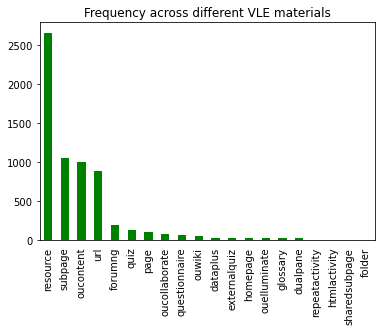

In [24]:
vle.activity_type.value_counts().plot(kind='bar',color="green")
plt.tick_params(bottom=False)
plt.title('Frequency across different VLE materials')

Merge the VLE interactions data with the VLE materials.

In [25]:
res_vle=  pd.merge(svle,vle,how='inner',left_on=("code_module","code_presentation","id_site"),right_on=("code_module","code_presentation","id_site"))
res_vle.drop(['week_from','week_to'],axis=1,inplace=True)
res_vle.head(3)

,code_module,code_presentation,id_student,id_site,date,sum_click,week,activity_type
0,AAA,2013J,28400,546652,-10,4,-2,forumng
1,AAA,2013J,28400,546652,-10,1,-2,forumng
2,AAA,2013J,28400,546652,-10,1,-2,forumng


The importance of the clickstreams aggregated by different materials on the dropout prediction is analyzed.

It will be useful to perform a prior identification of the dropouts (after weeks 5, weeks 10 etc.) 

For example, the analysis for the first five weeks can be performed as follows.

In [25]:
res_vle_w = res_vle[res_vle.week<=5]
stud_week_material = res_vle_w.groupby(['code_module','code_presentation','id_student','week','activity_type']).sum_click.sum().reset_index()
student_material = stud_week_material.groupby(['code_module','code_presentation','id_student','activity_type']).sum_click.sum().reset_index()
resource_processed =student_material.reset_index().groupby(['code_module','code_presentation','id_student','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
resource_processed.fillna(0,inplace=True)
resource_processed.head(5)

activity_type,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,0.0,0.0,0.0,80.0,0.0,58.0,0.0,...,316.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,23.0,1.0
1,AAA,2013J,28400,0.0,0.0,0.0,209.0,0.0,137.0,0.0,...,183.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,60.0,31.0
2,AAA,2013J,30268,0.0,0.0,0.0,126.0,0.0,59.0,0.0,...,66.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,0.0,0.0,0.0,178.0,1.0,139.0,0.0,...,263.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,66.0,28.0
4,AAA,2013J,32885,0.0,0.0,0.0,138.0,2.0,107.0,0.0,...,313.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,28.0,6.0


Similarly, the clickstreams aggregated by materials for the different weeks (5,10,15,20,25) will be analyzed.

It is useful to merge the clickstreams with the demographics to see how the model performance improves over weeks.

# LR on Demographics and clickstreams aggregated by VLE materials

In [53]:
def vle_week_resource_analysis(res_vle,week_selection,week_no, if_smote):
    
    res_vle_w = res_vle[res_vle.week<=week_selection]
    stud_week_material = res_vle_w.groupby(['code_module','code_presentation','id_student','week','activity_type']).sum_click.sum().reset_index()
    student_material = stud_week_material.groupby(['code_module','code_presentation','id_student','activity_type']).sum_click.sum().reset_index()
    resource_processed =student_material.reset_index().groupby(['code_module','code_presentation','id_student','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
    resource_processed.fillna(0,inplace=True)
    
    student_res_data=  pd.merge(students,resource_processed,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
    stu_resr_data=student_res_data.copy()
    stu_resr_data['code_presentation']=stu_resr_data.code_presentation.apply(lambda x: str(x)[-1])
    
    r_df = pd.get_dummies(stu_resr_data, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
    y = r_df.final_result
    X = r_df.drop(['final_result','id_student'],axis=1)
    x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=0)
    lr= LogisticRegression()
    
    if(if_smote):
        sm = SMOTE(random_state=1)
        x_train_d, y_train_d = sm.fit_sample(x_train_d, y_train_d.ravel())
        
    lr.fit(x_train_d,y_train_d)
    y_pred= lr.predict(x_test_d)

    
    print("Week",week_no,"  Accuracy: %.3f  F-Score:  %.3f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)),"\t10-fold  Accuracy %.3f\tF-Score:  %.3f" %(cross_val_score(lr,x_train_d,y_train_d,cv=10).mean()*100,cross_val_score(lr, x_train_d, y_train_d, cv=10, scoring='f1').mean()))

In [101]:
print("\t\t\tClickstreams Aggregated by VLE Materials")
print()
print("   Logistic Regression Results Without SMOTE  ")
print()
vle_week_resource_analysis(res_vle,5,'05',False)
vle_week_resource_analysis(res_vle,10,'10',False)
vle_week_resource_analysis(res_vle,15,'15',False)
vle_week_resource_analysis(res_vle,20,'20',False)
vle_week_resource_analysis(res_vle,25,'25',False)

			Clickstreams Aggregated by VLE Materials

   Logistic Regression Results Without SMOTE  

Week 05   Accuracy: 75.183  F-Score:  0.837 	10-fold  Accuracy 74.320	F-Score:  0.829
Week 10   Accuracy: 76.711  F-Score:  0.842 	10-fold  Accuracy 78.056	F-Score:  0.852
Week 15   Accuracy: 79.723  F-Score:  0.860 	10-fold  Accuracy 79.309	F-Score:  0.856
Week 20   Accuracy: 80.873  F-Score:  0.863 	10-fold  Accuracy 80.545	F-Score:  0.863
Week 25   Accuracy: 83.144  F-Score:  0.878 	10-fold  Accuracy 82.387	F-Score:  0.875


# SMOTE  : LR on Demographics and  clickstreams aggregated by materials

In [102]:
print("\t\t\tClickstreams Aggregated by VLE Materials")
print()
print("   Logistic Regression Results With SMOTE  ")
print()
vle_week_resource_analysis(res_vle,5,'05',True)
vle_week_resource_analysis(res_vle,10,'10',True)
vle_week_resource_analysis(res_vle,15,'15',True)
vle_week_resource_analysis(res_vle,20,'20',True)
vle_week_resource_analysis(res_vle,25,'25',True)

			Clickstreams Aggregated by VLE Materials

   Logistic Regression Results With SMOTE  

Week 05   Accuracy: 68.430  F-Score:  0.756 	10-fold  Accuracy 71.800	F-Score:  0.720
Week 10   Accuracy: 69.102  F-Score:  0.749 	10-fold  Accuracy 72.908	F-Score:  0.725
Week 15   Accuracy: 71.768  F-Score:  0.774 	10-fold  Accuracy 73.555	F-Score:  0.726
Week 20   Accuracy: 75.124  F-Score:  0.800 	10-fold  Accuracy 76.011	F-Score:  0.752
Week 25   Accuracy: 76.881  F-Score:  0.814 	10-fold  Accuracy 78.451	F-Score:  0.778


# Feed Forward Neural Network

# Demographic Data

In [63]:
df = pd.get_dummies(demo_data, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
y = df.final_result.values
X = df.drop(['final_result','id_student'],axis=1)
x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=0)

#transform the data
sc=StandardScaler()
x_train_d=sc.fit_transform(x_train_d)
x_test_d=sc.transform(x_test_d)

In [62]:
# define the Feed Forward Neural Network Architecture
def model_architecture(nodes):
    model= Sequential()
    model.add(Dense(output_dim=10,init='uniform',activation='relu',input_dim=nodes))
    model.add(Dense(output_dim=6,init='uniform',activation='relu'))
    model.add(Dense(output_dim=1, activation='sigmoid', init='uniform'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [65]:
model=model_architecture(x_train_d.shape[1])
model.fit(x_train_d,y_train_d,batch_size=32,epochs=10)

Epoch 1/10
19155/19155 [==============================] - 3s 149us/step - loss: 0.6369 - accuracy: 0.6428
Epoch 2/10
19155/19155 [==============================] - 1s 63us/step - loss: 0.6159 - accuracy: 0.6626
Epoch 3/10
19155/19155 [==============================] - 1s 57us/step - loss: 0.6138 - accuracy: 0.6642
Epoch 4/10
19155/19155 [==============================] - 1s 58us/step - loss: 0.6126 - accuracy: 0.6658
Epoch 5/10
19155/19155 [==============================] - 1s 60us/step - loss: 0.6112 - accuracy: 0.6676
Epoch 6/10
19155/19155 [==============================] - 1s 59us/step - loss: 0.6106 - accuracy: 0.6699
Epoch 7/10
19155/19155 [==============================] - 1s 59us/step - loss: 0.6094 - accuracy: 0.6681
Epoch 8/10
19155/19155 [==============================] - 1s 60us/step - loss: 0.6085 - accuracy: 0.6709
Epoch 9/10
19155/19155 [==============================] - 1s 59us/step - loss: 0.6076 - accuracy: 0.6711
Epoch 10/10
19155/19155 [=============================

In [66]:
y_pred=model.predict(x_test_d)
y_pred=[1 if y>=0.5 else 0 for y in y_pred ]
print()
print("Feed Forward Results on Demographic Details Without SMOTE")
print()
print("Accuracy: %.3f  F-Score:  %.3f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)))


Feed Forward Results on Demographic Details Without SMOTE

Accuracy: 66.583  F-Score:  0.755


# SMOTE Analysis on the Demographic data

In [67]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(x_train_d, y_train_d.ravel())
model.fit(X_train_res,y_train_res,batch_size=32,epochs=10)

Epoch 1/10
23100/23100 [==============================] - 1s 52us/step - loss: 0.6246 - accuracy: 0.6516
Epoch 2/10
23100/23100 [==============================] - 1s 56us/step - loss: 0.6217 - accuracy: 0.6545
Epoch 3/10
23100/23100 [==============================] - 1s 59us/step - loss: 0.6204 - accuracy: 0.6519
Epoch 4/10
23100/23100 [==============================] - 1s 58us/step - loss: 0.6194 - accuracy: 0.6536
Epoch 5/10
23100/23100 [==============================] - 1s 58us/step - loss: 0.6184 - accuracy: 0.6559
Epoch 6/10
23100/23100 [==============================] - 1s 58us/step - loss: 0.6174 - accuracy: 0.6587
Epoch 7/10
23100/23100 [==============================] - 1s 57us/step - loss: 0.6163 - accuracy: 0.6595
Epoch 8/10
23100/23100 [==============================] - 1s 60us/step - loss: 0.6162 - accuracy: 0.6620
Epoch 9/10
23100/23100 [==============================] - 1s 57us/step - loss: 0.6151 - accuracy: 0.6612
Epoch 10/10
23100/23100 [==============================

In [68]:
y_pred=model.predict(x_test_d)
y_pred=[1 if y>=0.5 else 0 for y in y_pred]
print()
print("Feed Forward Results on Demographic Details with SMOTE")
print()
print("Accuracy: %.3f  F-Score:  %.3f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)))


Feed Forward Results on Demographic Details with SMOTE

Accuracy: 65.863  F-Score:  0.711


# Feed Forward Cross-Validation

In [64]:
#10 fold cross validation for the Feed Forward Neural Network
def cross_val_feed_forward(x_tr,y_tr,input_size):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cvscores = []
    cv_fscores= []

    for train, test in kfold.split(x_tr, y_tr):
        model = model_architecture(input_size)
        model.fit(x_tr[train], y_tr[train], epochs=10, batch_size=32, verbose=0)

        y_test_rev= model.predict(x_tr[test])
        y_test_rev= [1 if y>=0.5 else 0 for y in y_test_rev]
        
        fscr =f1_score(y_test_rev,y_tr[test])
        cvscores.append(accuracy_score(y_test_rev,y_tr[test]))
        cv_fscores.append(fscr)
    
    return np.mean(cvscores)*100, np.mean(cv_fscores)

In [122]:
fold_score,fold_fscore =cross_val_feed_forward(x_train_d,y_train_d,38)
print("Feed Forward Cross Validation Results without SMOTE")
print()
print("10 fold Accuracy: %.3f  F-Score:  %.3f" % (fold_score, fold_fscore))

Feed Forward Cross Validation Results without SMOTE

10 fold Accuracy: 66.291  F-Score:  0.747


In [124]:
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(x_train_d, y_train_d.ravel())
fold_score_smote ,fold_fscore_smote  =cross_val_feed_forward(X_train_res,y_train_res,38)
print("Feed Forward Cross Validation Results with SMOTE")
print()
print("10 fold Accuracy: %.3f  F-Score:  %.3f" % (fold_score_smote, fold_fscore_smote))

Feed Forward Cross Validation Results with SMOTE

10 fold Accuracy: 64.485  F-Score:  0.647


# Feed Forward NN: Demographics and clickstreams aggregated by weeks

In [126]:
def vle_week_wise_ann_analysis(student_week_dt,week_selection,week_no, check_confusion_matrix,if_smote,nodes):
    
    student_week_dt = student_week_dt.iloc[:,0:week_selection]
    stu_vle_dt=student_week_dt.copy()
    stu_vle_dt['code_presentation']=stu_vle_dt.code_presentation.apply(lambda x: str(x)[-1])
    w_df = pd.get_dummies(stu_vle_dt, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
    y = w_df.final_result.values
    X = w_df.drop(['final_result','id_student'],axis=1).values
    x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=1)
    
    sc=StandardScaler()
    x_train_d=sc.fit_transform(x_train_d)
    x_test_d=sc.transform(x_test_d) 

    model= model_architecture(x_train_d.shape[1])
    
    if(if_smote):
        sm = SMOTE(random_state=1)
        x_train_d, y_train_d = sm.fit_sample(x_train_d, y_train_d.ravel())
    fold_acc, fold_fscore = cross_val_feed_forward(x_train_d,y_train_d,nodes)

    model.fit(x_train_d,y_train_d,batch_size=32,epochs=10,verbose=0)
    y_pred= model.predict(x_test_d)
    y_pred=[1 if y >=0.5 else 0 for y in y_pred]
   
    if(check_confusion_matrix):
        matrix=confusion_matrix(y_pred,y_test_d)
        print("\t\t\tActual Withdrawn\tActual Pass")
        print("Predicted Withdrawn \t{}\t\t\t{} \nPredicted Pass \t\t{}\t\t\t{}".format(matrix[0][0],matrix[0][1],matrix[1][0],matrix[1][1]))
    else:
        print("Week",week_no,"  Accuracy: %.2f  F-Score:  %.3f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)) ,"\t10-fold  Accuracy %.3f\tF-Score:  %.3f" %(fold_acc,fold_fscore))

In [127]:
print("\t\t\tClickstreams Aggregated by Weeks")
print()
print("   Feed Forward Neural Network Results Without SMOTE  ")
print()
vle_week_wise_ann_analysis(student_week_data,22,'05',False,False,48)
vle_week_wise_ann_analysis(student_week_data,27,'10',False,False,53)
vle_week_wise_ann_analysis(student_week_data,32,'15',False,False,58)
vle_week_wise_ann_analysis(student_week_data,37,'20',False,False,63)
vle_week_wise_ann_analysis(student_week_data,42,'25',False,False,68)
print()
print("   Confusion Matrix for Week 5 without SMOTE ")
print()
vle_week_wise_ann_analysis(student_week_data,22,'05',True,False,48)

			Clickstreams Aggregated by Weeks

   Feed Forward Neural Network Results Without SMOTE  

Week 05   Accuracy: 77.92  F-Score:  0.845 	10-fold  Accuracy 78.358	F-Score:  0.851
Week 10   Accuracy: 83.52  F-Score:  0.887 	10-fold  Accuracy 82.379	F-Score:  0.878
Week 15   Accuracy: 86.04  F-Score:  0.899 	10-fold  Accuracy 86.105	F-Score:  0.901
Week 20   Accuracy: 91.20  F-Score:  0.937 	10-fold  Accuracy 90.486	F-Score:  0.931
Week 25   Accuracy: 93.72  F-Score:  0.954 	10-fold  Accuracy 93.318	F-Score:  0.951

   Confusion Matrix for Week 5 without SMOTE 

			Actual Withdrawn	Actual Pass
Predicted Withdrawn 	979			415 
Predicted Pass 		818			3426


The number of correctly classified withdrawn cases increases with SMOTE oversampling.

In [128]:
print("\t\t\tClickstreams Aggregated by Weeks")
print()
print("   Feed Forward Neural Network Results With SMOTE  ")
print()
vle_week_wise_ann_analysis(student_week_data,22,'05',False,True,48)
vle_week_wise_ann_analysis(student_week_data,27,'10',False,True,53)
vle_week_wise_ann_analysis(student_week_data,32,'15',False,True,58)
vle_week_wise_ann_analysis(student_week_data,37,'20',False,True,63)
vle_week_wise_ann_analysis(student_week_data,42,'25',False,True,68)
print()
print("   Confusion Matrix for Week 5 with SMOTE")
print()
vle_week_wise_ann_analysis(student_week_data,22,'05',True,True,48)

			Clickstreams Aggregated by Weeks

   Feed Forward Neural Network Results With SMOTE  

Week 05   Accuracy: 74.76  F-Score:  0.808 	10-fold  Accuracy 75.786	F-Score:  0.767
Week 10   Accuracy: 80.45  F-Score:  0.855 	10-fold  Accuracy 79.984	F-Score:  0.813
Week 15   Accuracy: 84.62  F-Score:  0.885 	10-fold  Accuracy 85.426	F-Score:  0.860
Week 20   Accuracy: 90.10  F-Score:  0.927 	10-fold  Accuracy 89.901	F-Score:  0.902
Week 25   Accuracy: 92.94  F-Score:  0.948 	10-fold  Accuracy 92.921	F-Score:  0.930

   Confusion Matrix for Week 5 with SMOTE

			Actual Withdrawn	Actual Pass
Predicted Withdrawn 	1194			780 
Predicted Pass 		603			3061


# Feed Forward NN: Demographics & clickstreams aggregated by materials

In [56]:
def vle_week_resource_ann_analysis(res_vle,week_selection,week_no, if_smote):
    
    res_vle_w = res_vle[res_vle.week<=week_selection]
    stud_week_material = res_vle_w.groupby(['code_module','code_presentation','id_student','week','activity_type']).sum_click.sum().reset_index()
    student_material = stud_week_material.groupby(['code_module','code_presentation','id_student','activity_type']).sum_click.sum().reset_index()
    resource_processed =student_material.reset_index().groupby(['code_module','code_presentation','id_student','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
    resource_processed.fillna(0,inplace=True)
    student_res_data=  pd.merge(students,resource_processed,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
    stu_resr_data=student_res_data.copy()
    stu_resr_data['code_presentation']=stu_resr_data.code_presentation.apply(lambda x: str(x)[-1])
    
    r_df = pd.get_dummies(stu_resr_data, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
    y = r_df.final_result.values
    X = r_df.drop(['final_result','id_student'],axis=1).values
    x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=0)
    
    sc=StandardScaler()
    x_train_d=sc.fit_transform(x_train_d)
    x_test_d=sc.transform(x_test_d)     
    
    model= model_architecture(x_train_d.shape[1])
   
    if(if_smote):
        sm = SMOTE(random_state=1)
        x_train_d, y_train_d = sm.fit_sample(x_train_d, y_train_d.ravel())
    fold_acc, fold_fscore = cross_val_feed_forward(x_train_d,y_train_d,x_train_d.shape[1])

    model.fit(x_train_d,y_train_d,batch_size=32,epochs=10,verbose=0)
    y_pred= model.predict(x_test_d)
    y_pred=[1 if y >=0.5 else 0 for y in y_pred]
    
    print("Week",week_no,"  Accuracy: %.2f  F-Score:  %.3f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)) ,"\t10-fold  Accuracy %.3f\tF-Score:  %.3f" %(fold_acc,fold_fscore))

In [484]:
print("\t\t\tClickstreams Aggregated by VLE Materials")
print()
print("   Feed Forward Neural Network Results Without SMOTE  ")
print()
vle_week_resource_ann_analysis(res_vle,5,'05',False)
vle_week_resource_ann_analysis(res_vle,10,'10',False)
vle_week_resource_ann_analysis(res_vle,15,'15',False)
vle_week_resource_ann_analysis(res_vle,20,'20',False)
vle_week_resource_ann_analysis(res_vle,25,'25',False)

			Clickstreams Aggregated by VLE Materials

   Feed Forward Neural Network Results Without SMOTE  

Week 05   Accuracy: 77.11  F-Score:  0.845 	10-fold  Accuracy 77.000	F-Score:  0.842
Week 10   Accuracy: 78.24  F-Score:  0.848 	10-fold  Accuracy 79.834	F-Score:  0.862
Week 15   Accuracy: 81.75  F-Score:  0.873 	10-fold  Accuracy 81.321	F-Score:  0.870
Week 20   Accuracy: 84.37  F-Score:  0.890 	10-fold  Accuracy 83.314	F-Score:  0.882
Week 25   Accuracy: 86.14  F-Score:  0.901 	10-fold  Accuracy 85.534	F-Score:  0.898


In [65]:
print("\t\t\tClickstreams Aggregated by VLE Materials")
print()
print("   Feed Forward Neural Network Results With SMOTE  ")
print()
vle_week_resource_ann_analysis(res_vle,5,'05',True)
vle_week_resource_ann_analysis(res_vle,10,'10',True)
vle_week_resource_ann_analysis(res_vle,15,'15',True)
vle_week_resource_ann_analysis(res_vle,20,'20',True)
vle_week_resource_ann_analysis(res_vle,25,'25',True)

			Clickstreams Aggregated by VLE Materials

   Feed Forward Neural Network Results With SMOTE  

Week 05   Accuracy: 73.16  F-Score:  0.796 	10-fold  Accuracy 74.862	F-Score:  0.755
Week 10   Accuracy: 77.05  F-Score:  0.828 	10-fold  Accuracy 77.075	F-Score:  0.779
Week 15   Accuracy: 79.23  F-Score:  0.846 	10-fold  Accuracy 79.230	F-Score:  0.799
Week 20   Accuracy: 82.93  F-Score:  0.874 	10-fold  Accuracy 81.750	F-Score:  0.824
Week 25   Accuracy: 84.79  F-Score:  0.887 	10-fold  Accuracy 84.583	F-Score:  0.850


# LSTM on VLE data

LSTM expects the training data in [samples, time steps, features] format.

As the main objective of this research is prior identification of dropouts the time steps are kept low ( 5 ,10 ,15 weeks).

The clickstreams arranged in a multidimensional format are the input to the LSTM model. The clickstreams across 20 different VLE materials will be used as the features and for every student data is maintained across all the 38 weeks.

Thus the 3D data expected by LSTM illustrates that for all students we have per student 38 weeks and 20 resources.  

To keep a track of each courses and presentation a student takes, a unique id is created with a combination of student id, course and presentation.


In [26]:
# combine the demographic and VLE data
data_combined =  pd.merge(svle,vle,how='inner',left_on=("code_module","code_presentation","id_site"),right_on=("code_module","code_presentation","id_site"))
data_combined =  pd.merge(students,data_combined,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
data_combined.shape  

(9343518, 19)

It is important to analyze the eager students that access the course content in weeks(0-4) before the course commences.

In [27]:
early_week_data =data_combined[data_combined.week<0]

LSTM will analyze the clickstreams recorded in the rest 38 weeks of the on-going course.

In [28]:
data_combined=data_combined[data_combined.week>=0]
data_combined.drop(['week_from','week_to'],axis=1,inplace=True)

In [29]:
# aggregate the clickstreams over the 38 weeks for each of the twenty materials
data_combined=data_combined[['code_module','code_presentation','id_student','sum_click','final_result','week','activity_type']]
data_combined.sort_values(by=['id_student','code_module','code_presentation','week'],inplace=True)
aggr_data =data_combined.groupby(['id_student','code_module','code_presentation','week','final_result','activity_type'])['sum_click'].sum().reset_index()
aggr_data = aggr_data.reset_index().groupby(['id_student','code_module','code_presentation','week','final_result','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
aggr_data.fillna(0,inplace=True)

To arrange the 38 week clickstreams for each student and their enrolled course, it is necessary to create unique ids.

In [30]:
aggr_data['index_my']=aggr_data.groupby(['id_student','code_module','code_presentation']).ngroup()
aggr_data.iloc[35:55]

activity_type,id_student,code_module,code_presentation,week,final_result,dataplus,dualpane,externalquiz,folder,forumng,...,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,index_my
35,8462,DDD,2013J,1,0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,26.0,0.0,92.0,4.0,1
36,8462,DDD,2013J,2,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
37,8462,DDD,2013J,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,27.0,8.0,1
38,8462,DDD,2013J,4,0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,19.0,4.0,1
39,8462,DDD,2013J,5,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,1.0,1
40,8462,DDD,2013J,6,0,0.0,0.0,0.0,0.0,9.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,1
41,8462,DDD,2013J,7,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1
42,8462,DDD,2013J,8,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1
43,8462,DDD,2013J,10,0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,1
44,8462,DDD,2013J,11,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,1


There are such 21915 unique ids created.

In [31]:
all_index= aggr_data.index_my.unique()
len(all_index)

21915

There are some missing weeks of interactions found for the students. It is necessary to append zero clickstreams for these missing weeks so that each student can have exactly 38 weeks of clickstreams.

In [77]:
# create dataframe for clickstreams of missing weeks
df_new=aggr_data.iloc[0:1,:]
df_new.drop(0,axis=0,inplace=True)

In [78]:
# fill the zero padded clickstreams for missing weeks
row_no=0
complete_list=list(range(0, 39)) 
for index_current in all_index:
    missingItems = [x for x in complete_list if not x in  list(aggr_data[aggr_data.index_my==index_current].week)]
    stu_id= aggr_data[aggr_data.index_my==index_current]['id_student'].unique()[0]
    code_module= aggr_data[aggr_data.index_my==index_current]['code_module'].unique()[0]
    code_presentation= aggr_data[aggr_data.index_my==index_current]['code_presentation'].unique()[0]
    final_result= aggr_data[aggr_data.index_my==index_current]['final_result'].unique()[0]
    
    for item in missingItems:
        df_new=pd.DataFrame(np.insert(df_new.values, row_no, values=[stu_id, code_module,code_presentation,item,final_result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,index_current], axis=0))
        df_new.columns=aggr_data.columns
        row_no+1
df_new.to_csv('Missing_Weeks_Data_Records.csv')

In [501]:
missing_weeks_per_student= pd.read_csv('Missing_Weeks_Data_Records.csv',index_col=0)

# Multidimensional Clickstreams Data

In [465]:
# combine the missing weeks and the original data to get exactly 38 weeks per student
lstm_data =pd.concat([aggr_data, missing_weeks_per_student])

In [238]:
# arrange the clickstreams week-wise for each student and their courses
lstm_data=lstm_data.sort_values(by=['id_student','code_module','code_presentation','week'])
lstm_data.to_csv('LSTM_3D_Data.csv')

In [32]:
lstm_data= pd.read_csv('LSTM_3D_Data.csv',index_col=0)

In [33]:
lstm_data.shape

(854685, 26)

Check whether the data can be structured correctly to a multidimensional format by examining if (0 - 38) weeks exist for each id.

In [34]:
if (lstm_data.shape[0] /39 ==  len(all_index)):
    print("Data has been correctly generated")
    print("The LSTM data can be aligned to a multidimensional format")
else:
    print("Data cannot be structured correctly to a multidimensional format")

Data has been correctly generated
The LSTM data can be aligned to a multidimensional format


In [35]:
#extract the target label for the lstm data
y=[]
all_ind = lstm_data.index_my.unique()
for index in all_ind:
    y.append(lstm_data[lstm_data.index_my==index]['final_result'].unique()[0])

The initial 16500 students are considered in the training set. 
These students correspond to 16500 * 39 = 643500 rows of the lstm data.


The rest 5415 students are part of the test set.

In [36]:
# extract columns that correspond to the clickstreams across 20 resources
X_train = lstm_data.iloc[0:643500,5:25]
X_test =  lstm_data.iloc[643500:,5:25]

Out of 21915 unique ids the train set consists of 16500 ids and test set has 5415 entries.

In [37]:
y_train= np.array(y[0:16500])
y_test= np.array(y[16500:])

The lstm data is shaped into a multidimensional format (student * weeks * resources)

In [38]:
X_train_shaped= np.reshape(X_train.values,(16500,39,20))
X_test_shaped = np.reshape(X_test.values,(5415,39,20))

In [520]:
# week-wise lstm analysis
def week_lstm_analysis():
    weeks=['05','10','15','20','25']
    for week in weeks:
        X_train_week = X_train_shaped[:, :int(week), :]
        X_test_week  = X_test_shaped[:, :int(week), :]
        
        model = Sequential()
        model.add(LSTM(100,input_shape=(X_train_week.shape[1], X_train_week.shape[2]), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(60,return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(30))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.optimizer.learning_rate=0.001
        model.fit(X_train_week, np.array(y_train), epochs=5, batch_size=64,verbose=0)
        
        y_pred = model.predict(X_test_week)
        y_pred= [1 if y>=0.5 else 0 for y in y_pred]
        
        print("Week",week,"Accuracy: %.3f     F-Score:  %.3f" % (accuracy_score(y_test,y_pred)*100, f1_score(y_test,y_pred)))

In [521]:
print("\t\tLSTM Week Wise Analysis")
print()
week_lstm_analysis()

		LSTM Week Wise Analysis

Week 05 Accuracy: 77.101     F-Score:  0.853
Week 10 Accuracy: 83.472     F-Score:  0.890
Week 15 Accuracy: 87.295     F-Score:  0.914
Week 20 Accuracy: 91.782     F-Score:  0.943
Week 25 Accuracy: 94.903     F-Score:  0.965


# Model Prediction Probability over weeks

The probabilities predicted by the model over the weeks are analyzed to understand how a student instance is classified.

In [73]:
#function to observe the probabilities predicted by the LSTM model over the weeks 
def over_weeks(test_id):
    res=[]
    weeks=[5,10,15,20,25,30,35,38]
    for w in weeks:
        n_weeks_to_use = w
        X_train_week = X_train_shaped[:, :n_weeks_to_use, :]
        X_test_week  = X_test_shaped[:, :n_weeks_to_use, :]
        model = Sequential()
        model.add(LSTM(100,input_shape=(X_train_week.shape[1], X_train_week.shape[2]), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(60,return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(30))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.optimizer.learning_rate=0.001
        model.fit(X_train_week, np.array(y_train), epochs=5, batch_size=64,verbose=0)
        ans=X_test_week[test_id].reshape(1,w,20)
        y_prd=model.predict(ans)
        res.append(y_prd[0][0])
    return res

Example of True Negative Case: How the model predicts the pass student correctly.

Text(0.5, 1.0, 'Probability vs Week for LSTM\nTrue Negative Case')

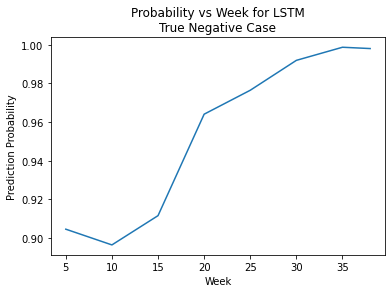

In [50]:
weeks=[5,10,15,20,25,30,35,38]
res=over_weeks(10)  #student actually passes 
grph=pd.DataFrame({"Prediction Probability":res,"Week":weeks})
sns.lineplot(data=grph,x="Week",y="Prediction Probability")
plt.title('Probability vs Week for LSTM\nTrue Negative Case')

Example of True Positive Case: How the model predicts the withdrawn student correctly.

Text(0.5, 1.0, 'Probability vs Week for LSTM\nTrue Positive Case')

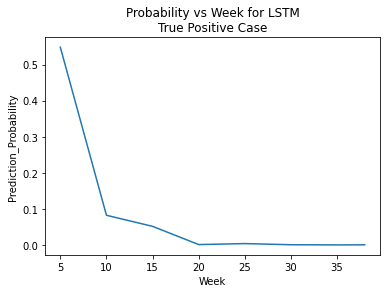

In [52]:
weeks=[5,10,15,20,25,30,35,38]
res=over_weeks(17)  #student actually withdraws 
grph=pd.DataFrame({"Prediction_Probability":res,"Week":weeks})
sns.lineplot(data=grph,x="Week",y="Prediction_Probability")
plt.title('Probability vs Week for LSTM\nTrue Positive Case')

# Observing the predicted probability over misclassified students by LSTM

The false positives and false negatives will be observed to find out how the predicted probability varies over the weeks and the model decision gets changed.
Also, it can be observed that the probability seems to oscillate and the model changes its decision towards the wrong class.

In [112]:
#this student actually passed the course
y_test[436]

1

Text(0.5, 1.0, 'Probability vs Week for LSTM\nFalse Positive Case')

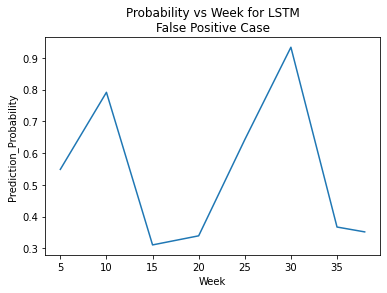

In [117]:
# wrong prediction by LSTM
res=over_weeks(436)   
grph=pd.DataFrame({"Prediction_Probability":res,"Week":weeks})
sns.lineplot(data=grph,x="Week",y="Prediction_Probability")
plt.title('Probability vs Week for LSTM\nFalse Positive Case')

In [113]:
#this student actually withdraws from the course
y_test[4814] 

0

Text(0.5, 1.0, 'Probability vs Week for LSTM\nFalse Negative Case')

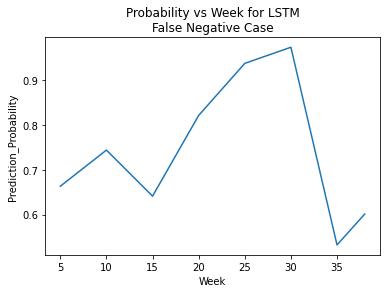

In [97]:
# wrong prediction by LSTM
weeks=[5,10,15,20,25,30,35,38]
res=over_weeks(4814)  
grph=pd.DataFrame({"Prediction_Probability":res,"Week":weeks})
sns.lineplot(data=grph,x="Week",y="Prediction_Probability")
plt.title('Probability vs Week for LSTM\nFalse Negative Case')

# Merge Model 

The Merge Model will be comprised of the:

        1)Feed-Forward Neural Network and the 
        2)Long Short Term Memory

Both these models will handle different data from the OULAD.

The demographics will be processed by the Feed-Forward Neural Network and the LSTM will analyze the VLE multidimensional 
clickstreams data.

In [55]:
lstm_stu_data =lstm_data[['id_student','code_module','code_presentation']]
lstm_stu_data.drop_duplicates(keep='first',inplace=True)

Merge the lstm students details with the other demographics to have the data in snyc for both the models.

In [56]:
lm=pd.merge(lstm_stu_data,students,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))

# Analysis of the Eager students

The eager student that access the course before it commences are identified and marked as being Early (binary feature).

This binary variable used to identify the eager students will be an input to the Feed Forward Neural Network.

Students that have aggregated clickstreams >= 50 in the early weeks are identified as Eager students.

In [57]:
# threshold is set as 50 for identifying eager students
early_week_data=early_week_data[['code_module','code_presentation','id_student','gender','region','highest_education','imd_band','age_band','num_of_prev_attempts','studied_credits','disability','final_result','week','sum_click']]
early_week_data.sort_values(by=['id_student','code_module','code_presentation','week'],inplace=True)
early_week_data['week']=-1
early_week_data.drop_duplicates(keep='first')
early_students_dt =early_week_data.groupby(['id_student','code_module','code_presentation','week']).sum_click.sum().reset_index()
early_students_dt['is_early']= early_students_dt.sum_click.apply(lambda x: "Early" if x>=50 else "Not Early")

In [58]:
lm.drop(['final_result'],axis=1,inplace=True)
early_students_dt.drop(['week','sum_click'],axis=1,inplace=True)

merger_data=pd.merge(lm,early_students_dt,how='left',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))

In [59]:
# the rest students not identified as eager will be assigned as Not Early
merger_data.is_early.fillna("Not Early",inplace=True)

In [60]:
demo_dt= merger_data.drop(['id_student'],axis=1)

In [61]:
demo_dt['code_presentation']=demo_dt.code_presentation.apply(lambda x: str(x)[-1])
demo_dt_dummies = pd.get_dummies(demo_dt, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability','is_early'],drop_first=True)

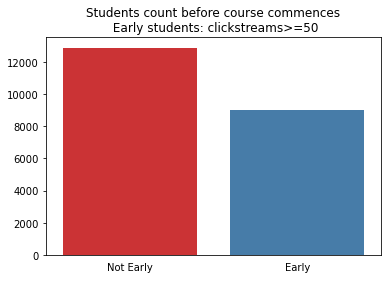

In [106]:
#distribution of eager students
sns.countplot('is_early',data=demo_dt,order = demo_dt['is_early'].value_counts().index,palette='Set1')
plt.ylabel('')
plt.xlabel(' ')
plt.title('Students count before course commences\n Early students: clickstreams>=50')
plt.tick_params(bottom=False)

The importance of is_early feature is checked on predicting the drop-outs.

The initial hypothesis is that this feature is an important feature in deciding the output.

However, the score of -0.13 suggests that this hypothesis is false as the value is low.

In [107]:
x_train_check= demo_dt_dummies.iloc[0:16500,:]
x_train_check['target'] = pd.Series(y_train)
x_train_check['is_early_Not Early'].corr(x_train_check['target'],method='pearson', min_periods=1)


-0.1355996330752412


# Merge Model using the Functional API in keras.

The demographics and multidimensional clickstreams inputs are separately initialized for the Feed Forward and LSTM respectively. The add utility in Keras will merge these explicitly defined inputs. There is a single output of the merge model to predicts the dropouts.

In [98]:
def week_merge_model_analysis():
    weeks=['05','10','15','20','25']
    for week in weeks:
        X_train_week = X_train_shaped[:, :int(week), :]
        X_test_week  = X_test_shaped[:, :int(week), :]
        x_train_d= demo_dt_dummies.iloc[0:16500,:]
        x_test_d= demo_dt_dummies.iloc[16500:,:]
        
        sc=StandardScaler()
        x_train_d=sc.fit_transform(x_train_d)
        x_test_d=sc.fit_transform(x_test_d)
        
        inputs1 = Input(shape=(39,))
        fe1 = Dropout(0.2)(inputs1)
        fe2 = Dense(100, activation='relu')(fe1)
        fe3 = Dense(60, activation='relu')(fe2)
        fe4 = Dense(30, activation='relu')(fe3)
        inputs2 = Input(shape=(X_train_week.shape[1], X_train_week.shape[2]))
        se2 = Dropout(0.2)(inputs2)
        se3 = LSTM(100,return_sequences=True)(se2)
        se4 = LSTM(60,return_sequences=True)(se3)
        se5 = LSTM(30)(se4)
        decoder1 = add([fe4, se5])
        outputs = Dense(1, activation='sigmoid')(decoder1)
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.optimizer.learning_rate=0.001
        model.fit([x_train_d,X_train_week], np.array(y_train), epochs=5,batch_size=64,verbose=0)

        y_pred = model.predict([x_test_d,X_test_week])
        y_pred= [1 if y>=0.5 else 0 for y in y_pred]
        
        print("Week",week,"Accuracy: %.3f     F-Score:  %.3f" % (accuracy_score(y_test,y_pred)*100, f1_score(y_test,y_pred)))

In [99]:
print("\t\tMerge Model Week Wise Analysis")
print()
week_merge_model_analysis()

		Merge Model Week Wise Analysis

Week 05 Accuracy: 79.280     F-Score:  0.866
Week 10 Accuracy: 84.118     F-Score:  0.896
Week 15 Accuracy: 87.941     F-Score:  0.918
Week 20 Accuracy: 92.004     F-Score:  0.944
Week 25 Accuracy: 94.922     F-Score:  0.965


# Model prediction over the weeks

The predicted dropout probabilities for student instances are observed over the weeks

In [99]:
def over_weeks_merge_performance(test_id):
    res=[]
    weeks=[5,10,15,20,25,30,35,38]
    for week in weeks:
        X_train_week = X_train_shaped[:, :week, :]
        X_test_week  = X_test_shaped[:, :week, :]
        x_train_d=demo_dt_dummies.iloc[0:16500,:]
        x_test_d=demo_dt_dummies.iloc[16500:,:]
        
        sc=StandardScaler()
        x_train_d=sc.fit_transform(x_train_d)
        x_test_d=sc.fit_transform(x_test_d)
        
        inputs1 = Input(shape=(39,))
        fe1 = Dropout(0.2)(inputs1)
        fe2 = Dense(100, activation='relu')(fe1)
        fe3 = Dense(60, activation='relu')(fe2)
        fe4 = Dense(30, activation='relu')(fe3)
        inputs2 = Input(shape=(X_train_week.shape[1], X_train_week.shape[2]))
        se2 = Dropout(0.2)(inputs2)
        se3 = LSTM(100,return_sequences=True)(se2)
        se4 = LSTM(60,return_sequences=True)(se3)
        se5 = LSTM(30)(se4)
        decoder1 = add([fe4, se5])
        outputs = Dense(1, activation='sigmoid')(decoder1)
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.optimizer.learning_rate=0.001
        model.fit([x_train_d,X_train_week], np.array(y_train), epochs=5,batch_size=64,verbose=0)

        lstm_inp=X_test_week[test_id].reshape(1,week,20)
        demo_inp =x_test_d[test_id].reshape(1,39)
       
        y_pred = model.predict([demo_inp,lstm_inp])

        res.append(y_pred[0][0])
    return res

# Observing the correct predictions by the Merge Model that were initially misclassified by LSTM

In [120]:
#this student actually passed the course
y_test[436]

1

Text(0.5, 1.0, 'Probability vs Week for LSTM\nTrue Positive Case')

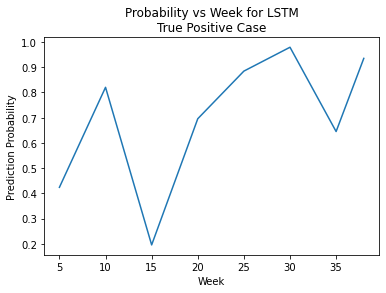

In [54]:
#correct prediction by the Merge model
res=over_weeks_merge_performance(436) 
weeks=[5,10,15,20,25,30,35,38]

grph=pd.DataFrame({"Prediction Probability":res,"Week":weeks})
sns.lineplot(data=grph,x="Week",y="Prediction Probability")
plt.title('Probability vs Week for LSTM\nTrue Positive Case')

In [121]:
#this student actually withdraws from the course
y_test[4814]

0

Text(0.5, 1.0, 'Probability vs Week for LSTM\nTrue Positive Case')

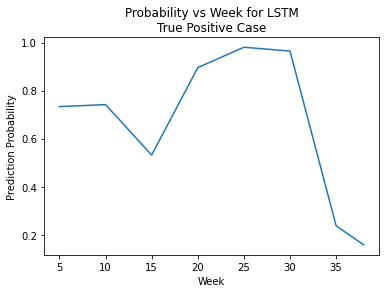

In [104]:
#correct prediction by the merge model
res=over_weeks_merge_performance(4814)   
grph=pd.DataFrame({"Prediction Probability":res,"Week":weeks})
sns.lineplot(data=grph,x="Week",y="Prediction Probability") 
plt.title('Probability vs Week for LSTM\nTrue Positive Case')

# Flask Demo: Virtual Learning Classification Application

In [17]:
from flask import Flask
from flask import render_template,request
StudentApp = Flask(__name__)

@StudentApp.route('/')
def student_form():
    return render_template('index.html')

@StudentApp.route('/', methods=['POST'])
def student_form_post():
    if(request.form['S_ID']):     
        student_id = request.form['S_ID']
        demo_details,mod_res=give_result(student_id)
        return render_template('studentDataDemo.html', demo_details=demo_details,mod_res=mod_res,no=len(mod_res))
    
if __name__ == '__main__':
    StudentApp.run(host='localhost', port=9177)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:9177/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Jul/2020 13:45:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2020 13:45:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2020 13:46:01] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2020 13:46:07] "GET / HTTP/1.1" 200 -


In [12]:
import pickle
pkl_filename = "pickle_model.pkl"
map_ans={1:"Pass",0:"Withdraw"}

with open(pkl_filename, 'rb') as f:
    pickle_model = pickle.load(f)
    
def give_result(sid):
    df = pd.get_dummies(students, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
    df=df[df.id_student==int(sid)]
    stud=students[students.id_student==int(sid)]
    code_modules =stud.code_module.values
    code_presentations=stud.code_presentation.values
    df=df.drop(['id_student','final_result'],axis=1)
    s=stud[['id_student','gender','region','highest_education','imd_band','age_band','disability']].iloc[0]
    demo_details={}
    for k in s.index:
        demo_details[k]=s[k]
    
    Ypredict = pickle_model.predict(df)
    mod_res=[]
    for i in range(0,len(Ypredict)):
        mod_res.append([code_modules[i],code_presentations[i],map_ans[Ypredict[i]]])
      
    return demo_details,mod_res